<h1>Sieci neuronowe - ćwiczenie 2</h1>

In [1]:
!pip install ucimlrepo


[notice] A new release of pip available: 22.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

<h3>Przygotowanie funkcji sigmoidu</h3>

In [3]:
def sigmoid(n: int) -> float:
    return 1 / (1 + np.exp(-n))

<h2>Przygotowanie modelu sieci neuronowej wykorzystującej regresję logistyczną</h2>
<ul>
<li>Zbieżność modelu można zdefiniować przez wystarczająco małą zmianę
funkcji kosztu w danej iteracji i pewną maksymalną liczbę iteracji
</li>
<li>
Model może uczyć się wyliczając sumaryczną pochodną z funkcji kosztu po
całym zbiorze
</li>
<li>
Uczenie się modelu powinno być weryfikowalne metryką (np. accuracy, fscore,
precision – biblioteka scikit learn (sklearn.metrics))
</li>
</ul>


In [4]:
class LogarithmicRegression:
    _weights: np.ndarray
    _bias: float

    def __init_weights(self, size: int) -> np.ndarray:
        return np.random.rand(size, 1) # initialize weights randomly
    
    def __gradient_weights(self, weights: np.ndarray, x: np.ndarray, y:np.ndarray, bias:float) -> np.ndarray:
        return -np.dot(x.T, (y - sigmoid(np.dot(x, weights) + bias))) / x.shape[0] #calculate gradient of weights using whole training data
    
    def __gradient_bias(self, weights: np.ndarray, x: np.ndarray, y:np.ndarray, bias:float) -> np.ndarray:
        return np.sum(-(y - sigmoid(np.dot(x, weights) + bias))) / x.shape[0] #calculate gradient of bias using whole training data
    
    def __cross_entropy_loss(self, weights: np.ndarray, x: np.ndarray, y:np.ndarray, bias:float) -> np.ndarray:
        return np.sum(-y*np.log(sigmoid(np.dot(x, weights) + bias)) - (1 - y)*np.log(1 - sigmoid(np.dot(x, weights) + bias))) / x.shape[0] #calculate loss using whole training data
    
    def __optimize(self, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, learning_rate: float, 
                       min_step: float, max_iter: int) -> (list, list, list, list, list, list, list):
        losses = []
        weights = []
        biases = []
        losses_test = []

        accuracy = []
        f_score = []
        precision = []
        for index in range(max_iter): #learn for max_iter

            old_train_loss = self.__cross_entropy_loss(self._weights, x_train, y_train, self._bias)

            #calculate new weight and bias using step    
            self._weights = self._weights - learning_rate * self.__gradient_weights(self._weights, x_train, y_train, self._bias)
            self._bias = self._bias - learning_rate * self.__gradient_bias(self._weights, x_train, y_train, self._bias)

            #calculate loss of training and testing data
            new_train_loss = self.__cross_entropy_loss(self._weights, x_train, y_train, self._bias)
            new_test_loss = self.__cross_entropy_loss(self._weights, x_test, y_test, self._bias)

            #append to helper lists
            losses.append(new_train_loss)
            weights.append(self._weights)
            biases.append(self._bias)
            losses_test.append(new_test_loss)

            #calculate scores for each iteration
            y_pred = self.predict(x_test)
            accuracy.append(metrics.accuracy_score(y_test, y_pred))
            f_score.append(metrics.f1_score(y_test, y_pred))
            precision.append(metrics.precision_score(y_test, y_pred))

            if min_step is not None and index > 0 and abs(old_train_loss - new_train_loss) <= min_step: #if change of loss is smaller or equal than min_step when stop learning
                break

        return losses, weights, biases, losses_test, accuracy, f_score, precision

    def logarithmicRegression(self, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, learning_rate: float, 
                       max_iter: int, min_step: float = None) -> (list, list, list, list, list, list, list): #model convergence criteria are min_step (loss step) and max_iter (amount of iterations)
        
        self._weights = self.__init_weights(x_train.shape[1])
        self._bias = np.random.rand() #initialize bias randomly

        #fix shape of y data to match further calculations
        if len(y_test.shape) == 1:
            y_test = y_test[np.newaxis].T 

        if len(y_train.shape) == 1:
            y_train = y_train[np.newaxis].T
        
        losses, weights, biases, losses_test, accuracy, f_score, precision = self.__optimize(x_train, y_train, x_test, y_test, learning_rate, min_step, max_iter) #optimize weights and bias using training data

        #plot results
        plt.plot(np.arange(len(losses)), losses, label="Train Loss")
        plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
        plt.plot(np.arange(len(losses)), accuracy, label="Accuracy")
        plt.plot(np.arange(len(losses)), f_score, label="F_score")
        plt.plot(np.arange(len(losses)), precision, label="Precision")
        plt.legend()
        plt.show()

        #print final weight, bias, loss and scores
        print("Weights: ", self._weights)
        print("Bias: ", self._bias)
        print("Train loss: ", losses[-1])
        print("Test loss: ", losses_test[-1])

        print("Scores")
        print("Accuracy: ", accuracy[-1])
        print("F_score: ", f_score[-1])
        print("Precision: ", precision[-1])

        return losses, weights, biases, losses_test, accuracy, f_score, precision

    def predict(self, x_test: np.ndarray) -> np.ndarray:
        
        y_pred = sigmoid(np.dot(x_test, self._weights) + self._bias) #calculate sigmoid for input data

        #change posibility from sigmoid to 1 or 0
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        
        return y_pred

        

<h3>Przygotowanie danych na podstawie poprzedniego ćwiczenia</h3>

In [5]:
# original code from https://archive.ics.uci.edu/dataset/45/heart+disease
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
heart_data = heart_disease.data.original

In [6]:
df: pd.DataFrame = heart_data

# repearing of the inbalnace in classification and removing null values
df["num"] = df["num"].replace([2, 3, 4], 1) #change classes to binary classification
print(df["num"].value_counts())

#get null values of ca and remove them
null_idx = df[df["ca"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

#get null values of thel and remove them
null_idx = df[df["thal"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

# balance classes to same amount 138
random_idx = df.query("num == 0").sample(df["num"].value_counts()[0] - df["num"].value_counts()[1]).index 
df = df.drop(random_idx)
df = df.reset_index(drop=True)
print(df["num"].value_counts())

df_without_num = df.loc[:, df.columns != "num"]
std_features = (df_without_num - df_without_num.mean() )/ df_without_num.std() #(value-mean)/variance

result = std_features
result["heart_disease"] = df["num"]

result

num
0    164
1    139
Name: count, dtype: int64
Index([166, 192, 287, 302], dtype='int64')
num
0    161
1    138
Name: count, dtype: int64
Index([87, 264], dtype='int64')
num
0    160
1    137
Name: count, dtype: int64
num
0    137
1    137
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,0.890906,0.68658,-2.211754,0.727363,-0.295561,2.450235,0.990968,0.055966,-0.715498,1.002134,2.280181,-0.753876,0.645220,0
1,1.326814,0.68658,0.848956,1.561709,0.711510,-0.406635,0.990968,-1.758287,1.392528,0.330162,0.636051,2.407787,-0.901051,1
2,1.326814,0.68658,0.848956,-0.663214,-0.371566,-0.406635,0.990968,-0.851160,1.392528,1.254123,0.636051,1.353899,1.160643,1
3,-1.942494,0.68658,-0.171281,-0.106983,0.027462,-0.406635,-1.020330,1.654237,-0.715498,2.010092,2.280181,-0.753876,-0.901051,0
4,-1.506586,-1.45118,-1.191517,-0.106983,-0.846600,-0.406635,0.990968,1.006290,-0.715498,0.246165,-1.008080,-0.753876,-0.901051,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,0.237045,-1.45118,0.848956,0.449248,-0.143550,-0.406635,-1.020330,-1.110340,1.392528,-0.761793,0.636051,-0.753876,1.160643,1
270,-1.070679,0.68658,-2.211754,-1.219445,0.293481,-0.406635,-1.020330,-0.721571,-0.715498,0.078172,0.636051,-0.753876,1.160643,1
271,1.435791,0.68658,0.848956,0.671740,-1.055615,2.450235,-1.020330,-0.332802,-0.715498,1.926095,0.636051,1.353899,1.160643,1
272,0.237045,0.68658,0.848956,-0.106983,-2.233698,-0.406635,-1.020330,-1.455912,1.392528,0.078172,0.636051,0.300012,1.160643,1


<h1>Przetestowanie działania modelu</h1>

<h3>Weryfikacja powinna uwzględnić podział na dane uczące i testowe</h3>

In [7]:
def train_test_split(features, targets, percentage):
    choices = np.random.choice(range(features.shape[0]), size=(int(features.shape[0] * percentage/100),), replace=False) 
    split = np.zeros(features.shape[0], dtype=bool)
    split[choices] = True

    return features[split], targets[split], features[~split], targets[~split]

In [8]:
features = result.loc[:, result.columns != "heart_disease"].to_numpy()
targets = result["heart_disease"].to_numpy()

x_train, y_train, x_test, y_test = train_test_split(features, targets, 70)

<h3>Test modelu na danych z ćwiczenia 1</h3>

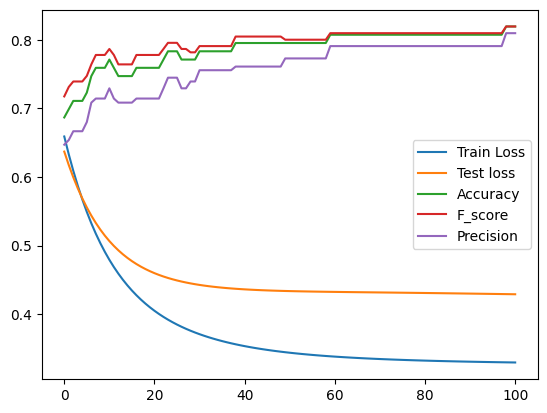

Weights:  [[ 0.19350615]
 [ 0.76280251]
 [ 0.83639206]
 [ 0.14906268]
 [ 0.20720191]
 [-0.16312417]
 [ 0.07329881]
 [-0.20040283]
 [ 0.6050176 ]
 [ 0.54295831]
 [ 0.03689757]
 [ 0.9300617 ]
 [ 0.60871604]]
Bias:  0.3629795783510626
Train loss:  0.32977585274335675
Test loss:  0.4291614180650945
Scores
Accuracy:  0.8192771084337349
F_score:  0.8192771084337348
Precision:  0.8095238095238095


In [9]:
max_iter = 200

ex1 = LogarithmicRegression()

result_ex1 = ex1.logarithmicRegression(x_train, y_train, x_test, y_test, 0.2, max_iter, 0.0001)

<p><i>Wykonane przez Szymona Sawczuka nr indeksu 260287</i></p>